In [2]:
### In this project, I will use datatable (quicker) rather pandas to manipulate data. You can see which one is more intuitive for you 
from datetime import datetime
import datatable as dt
from datatable import dt, f, by, update
from regpyhdfe import Regpyhdfe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

#### Q1: Simulation 
Simulate Bid-ask spread dynamics for the following question: 
* The end-of-day value of a share of stock, V, is random
* At market close: either $V_H$=150 or $V_L$=100
    * With equal probability
* Before trading starts, the expected value is
    * EV=$\frac{1}{2}150 + \frac{1}{2} 100$=125
    * This is the unconditional expected value
* There are two types of traders
    * Informed traders know V
    * Uninformed (``retail'') traders don't know V
* The dealer doesn't know V
* Uninformed traders are equally likely to buy or sell
* Informed traders observe V and decide the optimal trading strategy 
* After the dealer sets the bid and ask quote, a trader arrives. 
    * Assuming: Prob(uninformed) = 0.8 and Prob(informed) = 0.2


Plot Bid-ask spread dynamics for the following two scenarios (b is buy order and s is sell order)
1) s,s,b,s,s,b,s,s,s,s,s,s
2) s,b,b,s,b,b,s,b,b,b,b,b


#### Import the relevant modules

Text(0, 0.5, 'Price')

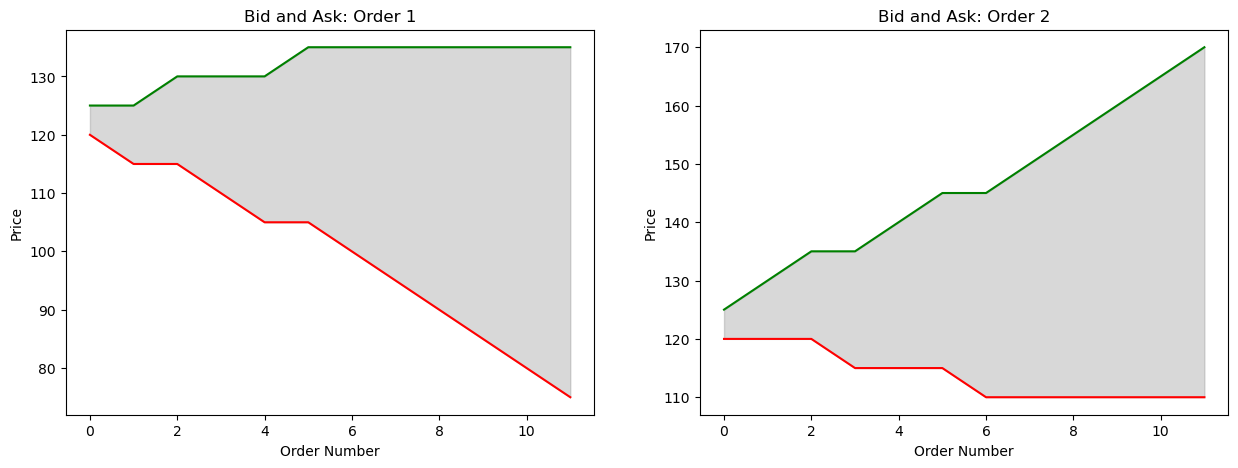

In [4]:
# Set probabilities
speculator = 0.2 #pi

# Initial Value
ev = 125 
theta = .5 #Probability buy

# Set orders
order_1 = ['s','s','b','s','s','b','s','s','s','s','s','s']
order_2 = ['s','b','b','s','b','b','s','b','b','b','b','b']

# Set final prices. Not sure how to utilize that yet
V_h = 150
V_l = 100

def simulate_bid_ask(orders):
    'This function simulates bid-ask spread based on users input of buy/sell orders.'
    bids = []
    asks = []
    # Set initial spread to two
    bid_price = ev - .01
    ask_price = ev + .01
    # Iterate through order list, set new bid/ask price
    for order in orders:
        if order.lower() == 's':
            bid_price -= (theta*(1-theta)*speculator)/((1-speculator)*(1/2)+speculator*(1-theta))*(V_h - V_l)
        elif order.lower() == 'b':
            ask_price += (theta*(1-theta)*speculator)/((1-speculator)*(1/2)+speculator*(1-theta))*(V_h - V_l)

        # Append prices to the list
        bids.append(bid_price)
        asks.append(ask_price)
    return bids, asks

# Simulate both orders
bids_simulation_1, asks_simulation_1 = simulate_bid_ask(order_1)
bids_simulation_2, asks_simulation_2 = simulate_bid_ask(order_2)

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(bids_simulation_1, color='red')
ax[0].plot(asks_simulation_1, color='green')
ax[0].fill_between(range(len(bids_simulation_1)), bids_simulation_1, asks_simulation_1, color='gray', alpha=0.3)
ax[0].set_title('Bid and Ask: Order 1')
ax[0].set_xlabel('Order Number')
ax[0].set_ylabel('Price')

ax[1].plot(bids_simulation_2, color='red')
ax[1].plot(asks_simulation_2, color='green')
ax[1].fill_between(range(len(bids_simulation_2)), bids_simulation_2, asks_simulation_2, color='gray', alpha=0.3)
ax[1].set_title('Bid and Ask: Order 2')
ax[1].set_xlabel('Order Number')
ax[1].set_ylabel('Price')

#### Q2: Data cleanning and data analysis 
This exercise is about ﬁxed income markets. Corporate bonds are largely traded in OTC markets. Academic Corporate Bond TRACE Dataset contains historic transaction-level data on all eligible corporate bondsinvestment grade, high yield and convertible debt. We use this dataset to understand the bond market during the COVID-19 Crisis.

* bond.csv.zip is the dataset containing TRACE data downloaded from WRDS
* VariableList.csv contains the variable description, and more detailed description is in TRACE Variable.pdf
* I will not give you instructions to clean the data. You need to underrstand what variables to use and decide your way to handle the data 

##### Data Cleaning 
* How many different companies and corporate bonds are in the data set?
  #### - There are five companies and 156 bonds. 

* Plot the histogram of the number of trading days 

* The data reports the contra-party type. 
    * Calculate spread for each trade as follows. Note that we do not see bid/ask prices at OTC markets, so the calculation of spread is not direct. We follow the calculation in
    $$spread = 2Q * \frac{traded price - reference price}{referenc price}$$
    where Q is +1 for a customer buy and −1 for a customer sell. For each trade, we calculate its reference price as the volume-weighted average price of trades in the same bond-day
    * Plot the histogram of calculated trade spread. Do you notice that 1) lots of spreads are exactly zero, 2) there are entries with very large spreads? Please answer why those spreads are zero? Give one example to explain outlier spreads (check news and list one example that may lead to large spreads)
  #### - Yes. There are many spreads that are zero, and some spreads are pretty wide. My intuition tells me that this would be something that has to do with credit risk and overall risk. Just like MMs widen the spread at the time of high volatility, they would narrow the spread when risks are low and they want to stimulate liquidity. 
  #### - An example of a widened bid-ask spread would be a time of unusually high volatility in the market. If we are talking about the bonds market in theory, maybe it has something to do with the Fed and predictions whether rates will go up or down. 

##### Analysis
* Daily analysis 
    * Spread
        * Aggregate spread information to the company-day level. What is the reasonable way in your opinions to do this?
          #### - We can always filter the database by company and day. The question is, what kind of valuable finding would this help me achieve?
        * Using bond-day level spreads to calculate the average spread for each stock and present the results. What can we learn from the ranking of the spreads?
        * Plot time-series spread using company-day level data for each company. What patterns do you see, and why is that?
    * Volume 
        * Calculate company-day trading volume for each company
        * Plot histogram of the company-day trading volume. What is the distribution?
         #### - Both histogram and volume are plotted below.
    * Analysis
        * Does past trading volume predicts future spreads?
          #### Based on the time series, I'd say no. We need a more sophisticated analysis.
        * Are daily trading volume time-series correlated? 
        #### Again, need a more sophisticated analysis.

* Intraday analysis 
    * Spread
        * For each company, construct and plot the intraday spread pattern by minutes 
    * Volume 
        * For each company, construct and plot the intraday volume pattern by minutes
          #### Plotted below.
    * Analysis 
        * Does the interday pattern change during market stress periods?
          #### It looks like more volume happens in the morning, and that pattern stays somewhat consistent. 
        * Is intraday volume predictable? (Note that you can also construct interday return information)
          #### Ideally, we'd want to run AR to see, but I don't think that volume is a stationary process.

In [32]:
# Read the data
df = pd.read_csv('bond.csv')
df.head(-5)

/var/folders/vv/3nnd1g4506z6vdqnf44fkr2c0000gn/T/ipykernel_17818/1162086263.py:1: DtypeWarning: Columns (16,22,27,30,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('bond.csv')


,cusip_id,bond_sym_id,company_symbol,bsym,trd_exctn_dt,trd_exctn_tm,sub_prd_type,trans_dt,msg_seq_nb,trc_st,...,rptd_last_pr,lsal_yld_sign_cd,lsal_yld_pt,orig_dis_dt,orig_msg_seq_nb,function,sttl_dt,rptg_party_type,contra_party_type,ATS_indicator
0,903436AA1,AAL3604479,AAL,BBG001RYS1P3,20200107,14:50:35,CORP,20200107,50555,M,...,NaN,NaN,NaN,NaN,NaN,NaN,20200109,D,C,NaN
1,903436AA1,AAL3604479,AAL,BBG001RYS1P3,20200107,14:50:35,CORP,20200107,50556,M,...,NaN,NaN,NaN,NaN,NaN,NaN,20200109,D,D,NaN
2,903436AA1,AAL3604479,AAL,BBG001RYS1P3,20200107,15:00:13,CORP,20200107,52469,M,...,NaN,NaN,NaN,NaN,NaN,NaN,20200109,D,C,NaN
3,903436AA1,AAL3604479,AAL,BBG001RYS1P3,20200107,15:00:13,CORP,20200107,52518,M,...,NaN,NaN,NaN,NaN,NaN,NaN,20200109,D,D,NaN
4,903436AA1,AAL3604479,AAL,BBG001RYS1P3,20200108,14:28:02,CORP,20200108,48599,M,...,NaN,NaN,NaN,NaN,NaN,NaN,20200110,D,D,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275655,88160RAG6,TSLA4830349,TSLA,BBG00P2DPCT8,20201230,15:42:40,CORP,20201230,36357,M,...,NaN,NaN,NaN,NaN,NaN,NaN,20201231,D,C,NaN
275656,88160RAG6,TSLA4830349,TSLA,BBG00P2DPCT8,20201230,15:47:31,CORP,20201230,36836,M,...,NaN,NaN,NaN,NaN,NaN,NaN,20210104,D,C,NaN
275657,88160RAG6,TSLA4830349,TSLA,BBG00P2DPCT8,20201231,10:07:00,CORP,20201231,4505,M,...,NaN,NaN,NaN,NaN,NaN,NaN,20210105,D,C,NaN
275658,88160RAG6,TSLA4830349,TSLA,BBG00P2DPCT8,20201231,11:45:45,CORP,20201231,12589,M,...,NaN,NaN,NaN,NaN,NaN,NaN,20210105,D,C,NaN


In [54]:
# Find companies and bonds
companies = pd.DataFrame(df['company_symbol'].value_counts())
print('Traded companies', len(companies), ':\n',companies, '\n')
bonds = pd.DataFrame(df['bond_sym_id'].value_counts())
print('Traded bonds', len(bonds),':\n', bonds)

Traded companies 5 :
       company_symbol
AAPL          172019
AMZN           56261
TSLA           22124
AAL            17651
AMC             7610 

Traded bonds 156 :
              bond_sym_id
AAPL4001809        16064
AAPL4336441        12338
TSLA4530907        11302
AAPL4122392         9966
AAPL4122390         6805
...                  ...
TSLA4265473            2
TSLA4231716            2
TSLA4230053            2
AMC5128458             1
AMC5076724             1

[156 rows x 1 columns]


In [56]:
# Calculate frequency
trading_frequency_df = df['trd_exctn_dt'].value_counts().sort_index()
trading_frequency_df

20200102    1049
20200103     850
20200106    1028
20200107    1164
20200108    1266
            ... 
20201224     321
20201228     663
20201229     768
20201230     805
20201231     386
Name: trd_exctn_dt, Length: 272, dtype: int64

#### Number of Trading days per bond

(array([2.1097e+04, 1.9000e+01, 5.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.5580e+02, 3.1060e+02, 4.6540e+02, 6.2020e+02,
        7.7500e+02, 9.2980e+02, 1.0846e+03, 1.2394e+03, 1.3942e+03,
        1.5490e+03, 1.7038e+03, 1.8586e+03, 2.0134e+03, 2.1682e+03,
        2.3230e+03, 2.4778e+03, 2.6326e+03, 2.7874e+03, 2.9422e+03,
        3.0970e+03]),
 <BarContainer object of 20 artists>)

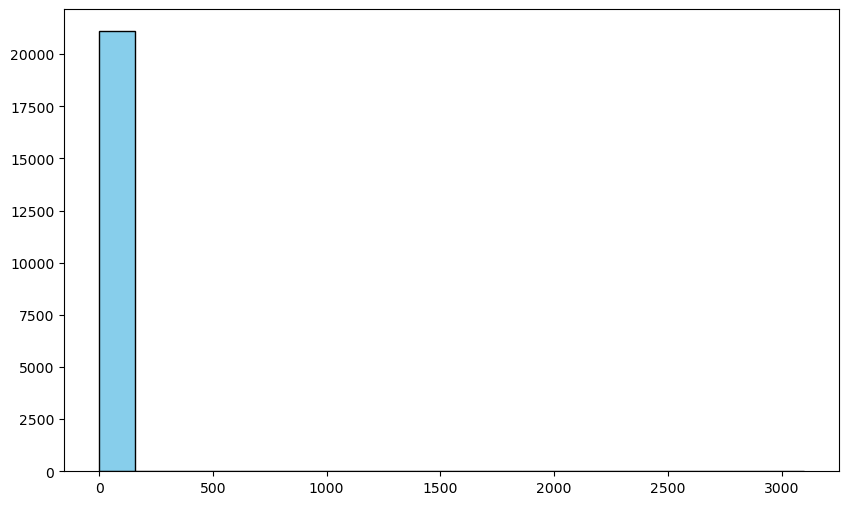

In [96]:
# Plot number of trading days per bond
trading_days_df = df.groupby(['cusip_id', 'trd_exctn_dt']).size().reset_index(name='trade_count')
plt.figure(figsize=(10, 6))
plt.hist(trading_days_df['trade_count'], bins=20, color='skyblue', edgecolor='black')

#### Bond Spreads

/var/folders/vv/3nnd1g4506z6vdqnf44fkr2c0000gn/T/ipykernel_17818/3560907841.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_data['ascii_rptd_vol_tx'] = pd.to_numeric(trade_data['ascii_rptd_vol_tx'], errors='coerce')
/var/folders/vv/3nnd1g4506z6vdqnf44fkr2c0000gn/T/ipykernel_17818/3560907841.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trade_data_cleaned['trd_exctn_tm'] = pd.to_datetime(trade_data_cleaned['trd_exctn_tm'], format='%H:%M:%S').dt.time


Text(0.5, 1.0, 'Histogram of Calculated Trade Spreads')

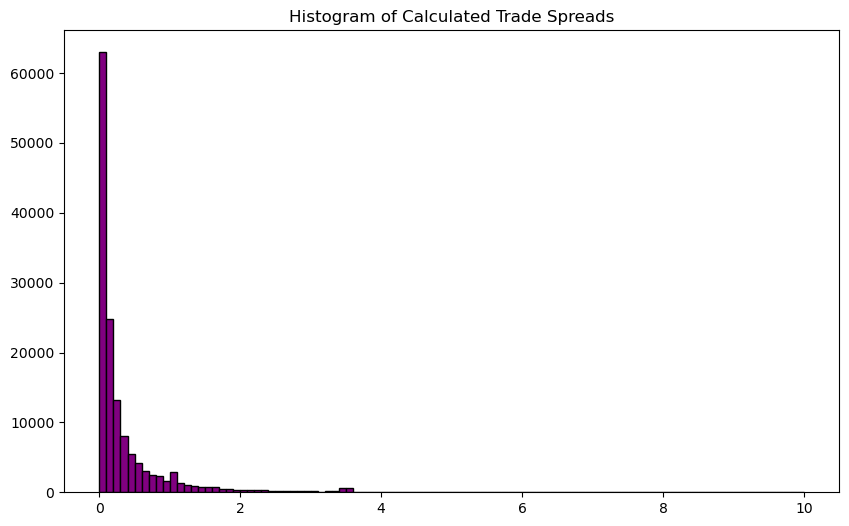

In [64]:
# CODE CREDIT CHATGPT FOR THIS CHUNK

trade_data = df[['cusip_id', 'trd_exctn_dt', 'trd_exctn_tm', 'contra_party_type', 'rptd_pr', 'ascii_rptd_vol_tx']]

# Converting 'ascii_rptd_vol_tx' to numeric, handling errors by coercing them to NaN
trade_data['ascii_rptd_vol_tx'] = pd.to_numeric(trade_data['ascii_rptd_vol_tx'], errors='coerce')

# Dropping rows with NaN values in 'rptd_pr' or 'ascii_rptd_vol_tx' as they are essential for the calculation
trade_data_cleaned = trade_data.dropna(subset=['rptd_pr', 'ascii_rptd_vol_tx'])

# Converting trade execution time to datetime format for sorting purposes
trade_data_cleaned['trd_exctn_tm'] = pd.to_datetime(trade_data_cleaned['trd_exctn_tm'], format='%H:%M:%S').dt.time

# Sorting trades by bond, day, and execution time to ensure chronological order for the calculation
trade_data_sorted = trade_data_cleaned.sort_values(by=['cusip_id', 'trd_exctn_dt', 'trd_exctn_tm'])

# Calculating the VWAP for trades in the same bond-day
vwap_df = trade_data_sorted.groupby(['cusip_id', 'trd_exctn_dt']).apply(
    lambda x: (x['rptd_pr'] * x['ascii_rptd_vol_tx']).sum() / x['ascii_rptd_vol_tx'].sum()
).reset_index(name='vwap')

# Merging the original trade data with the VWAP data to have the reference price for each trade
trade_data_with_vwap = trade_data_sorted.merge(vwap_df, on=['cusip_id', 'trd_exctn_dt'], how='left')

trade_data_with_vwap['Q'] = trade_data_with_vwap['contra_party_type'].map({'C': 1, 'D': -1})

# Calculating the spread for each trade
# Spread = | Trade Price - VWAP | * Q
trade_data_with_vwap['spread'] = abs(trade_data_with_vwap['rptd_pr'] - trade_data_with_vwap['vwap']) * trade_data_with_vwap['Q']

plt.figure(figsize=(10, 6))
plt.hist(trade_data_with_vwap['spread'], bins=100, range=[0, 10], color='purple', edgecolor='black')  # Limiting range for better visualization
plt.title('Histogram of Calculated Trade Spreads')

#### Daily Trading Volume

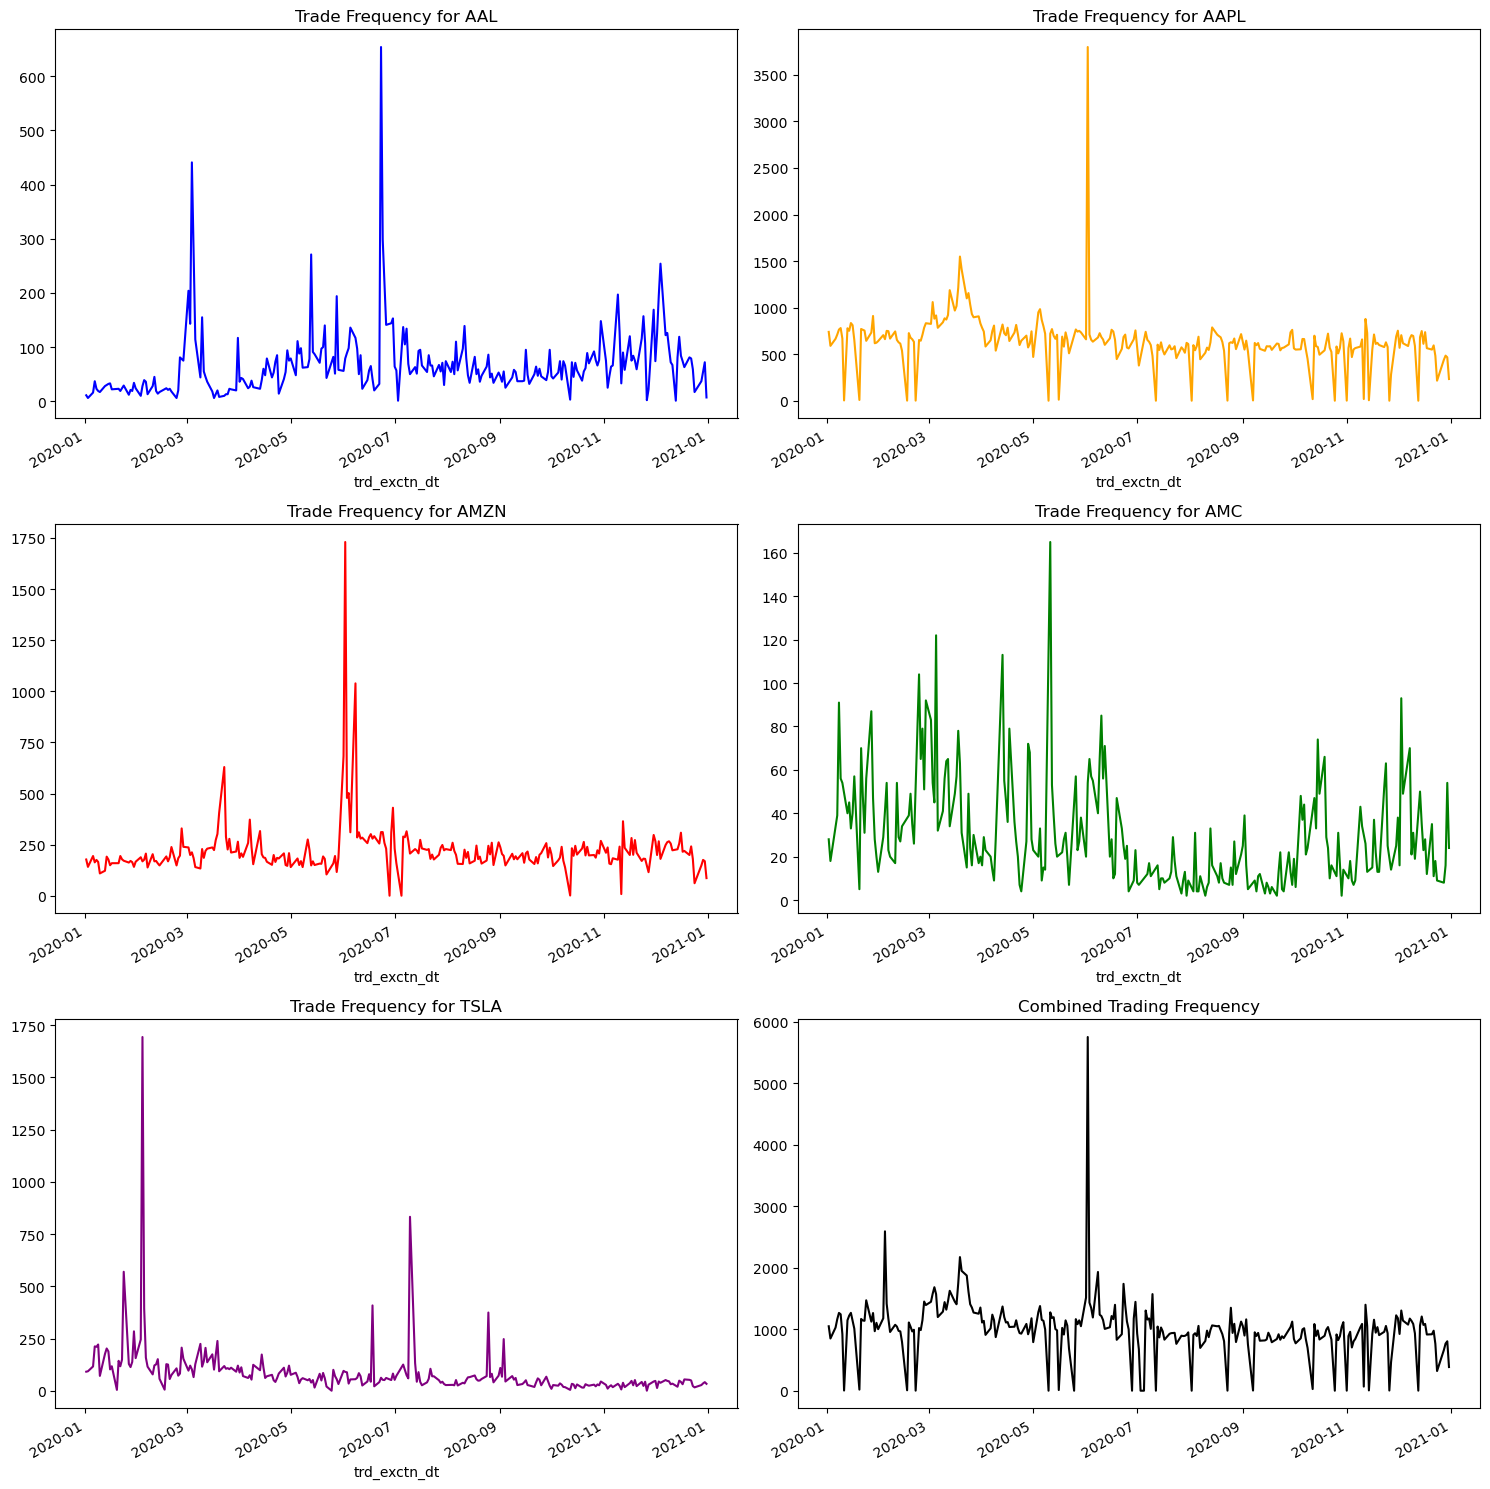

In [93]:
df['trd_exctn_dt'] = pd.to_datetime(df['trd_exctn_dt'], format='%Y%m%d')

# Get AAL
AAL_data = df[df['company_symbol'] == 'AAL']
AAL_frequency = AAL_data.groupby('trd_exctn_dt').size()
# Get AAPL
AAPL_data = df[df['company_symbol'] == 'AAPL']
AAPL_frequency = AAPL_data.groupby('trd_exctn_dt').size()
# Get AMZN
AMZN_data = df[df['company_symbol'] == 'AMZN']
AMZN_frequency = AMZN_data.groupby('trd_exctn_dt').size()
# Get AMC
AMC_data = df[df['company_symbol'] == 'AMC']
AMC_frequency = AMC_data.groupby('trd_exctn_dt').size()
# Get TSLA
TSLA_data = df[df['company_symbol'] == 'TSLA']
TSLA_frequency = TSLA_data.groupby('trd_exctn_dt').size()
# Get the total trade frequency by day
trading_frequency_df.index = pd.to_datetime(trading_frequency_df.index, format='%Y%m%d')

# Plotting the frequencies
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
AAL_frequency.plot(ax=ax[0, 0], title='Trade Frequency for AAL', color = 'blue')
AAPL_frequency.plot(ax=ax[0, 1],title='Trade Frequency for AAPL', color = 'orange')
AMZN_frequency.plot(ax=ax[1, 0],title='Trade Frequency for AMZN', color = 'red')
AMC_frequency.plot(ax=ax[1, 1],title='Trade Frequency for AMC', color = 'green')
TSLA_frequency.plot(ax=ax[2, 0],title='Trade Frequency for TSLA', color = 'purple')
trading_frequency_df.plot(ax=ax[2, 1], title='Combined Trading Frequency', color='black')
plt.tight_layout()

#### Get Average and Daily Spread. Plot it for 5 companies

In [103]:
# Convert to daytime to make it easy for us. 
df['trd_exctn_dt'] = pd.to_datetime(df['trd_exctn_dt'], format='%Y%m%d')
df['trd_exctn_tm'] = pd.to_datetime(df['trd_exctn_tm'], format='%H:%M:%S').dt.time

# Get daily spread by calculating the standard deviation of reported prices for each stock per day
daily_spreads = df.groupby(['company_symbol', 'trd_exctn_dt'])['rptd_pr'].std().reset_index()

# Calculate the average spread for each company bonds
average_spreads = daily_spreads.groupby('company_symbol')['rptd_pr'].mean().reset_index()
average_spreads.rename(columns={'rptd_pr': 'average_spread'}, inplace=True)

# Calculate trading volume by summing 'ascii_rptd_vol_tx' for each company per day
df['ascii_rptd_vol_tx'] = pd.to_numeric(df['ascii_rptd_vol_tx'], errors='coerce')  # Convert to numeric, coercing errors
daily_volumes = df.groupby(['company_symbol', 'trd_exctn_dt'])['ascii_rptd_vol_tx'].sum().reset_index()

average_spreads, daily_volumes.head()

(  company_symbol  average_spread
 0            AAL       11.229666
 1           AAPL        7.540734
 2            AMC        3.190008
 3           AMZN       10.818714
 4           TSLA      159.201571,
   company_symbol trd_exctn_dt  ascii_rptd_vol_tx
 0            AAL   2020-01-02          136277.16
 1            AAL   2020-01-03          157775.10
 2            AAL   2020-01-06         2303216.37
 3            AAL   2020-01-07         1743896.95
 4            AAL   2020-01-08          572984.86)

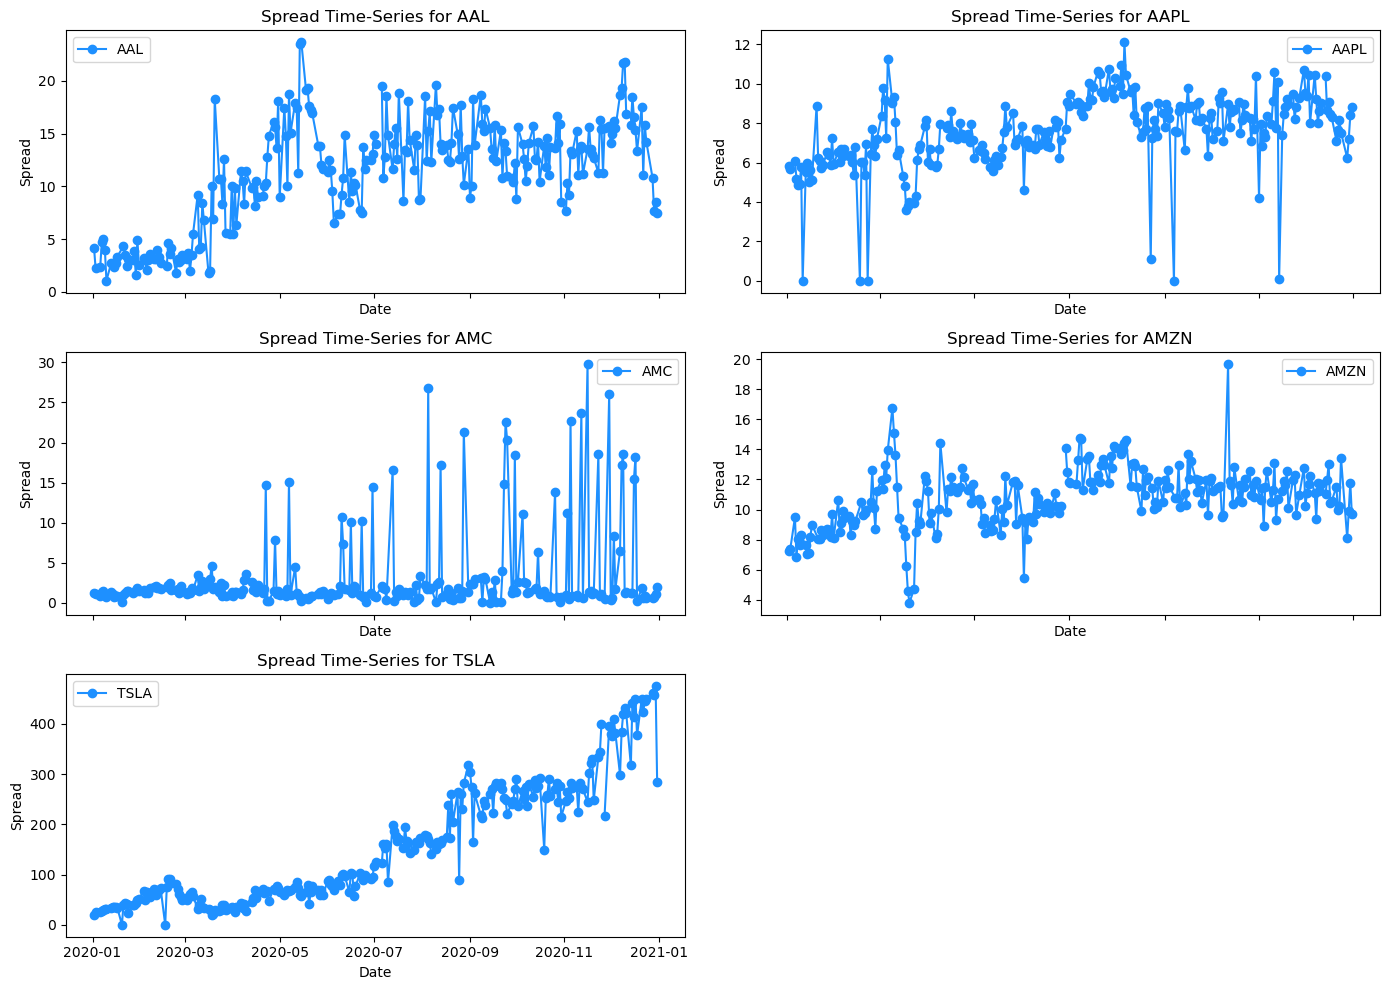

In [107]:
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10), sharex=True)
axes = axes.flatten()  # Flatten to iterate easily
companies = daily_spreads['company_symbol'].unique()

# Iterate through companies and add plots for each one
for i, company in enumerate(companies):
    company_data = daily_spreads[daily_spreads['company_symbol'] == company]
    axes[i].plot(company_data['trd_exctn_dt'], company_data['rptd_pr'], label=company, marker='o', linestyle='-', color='dodgerblue')
    axes[i].set_title(f'Spread Time-Series for {company}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Spread')
    axes[i].legend()

# Adjust layout and remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
fig.tight_layout()

plt.show()

#### Plot volume histograms

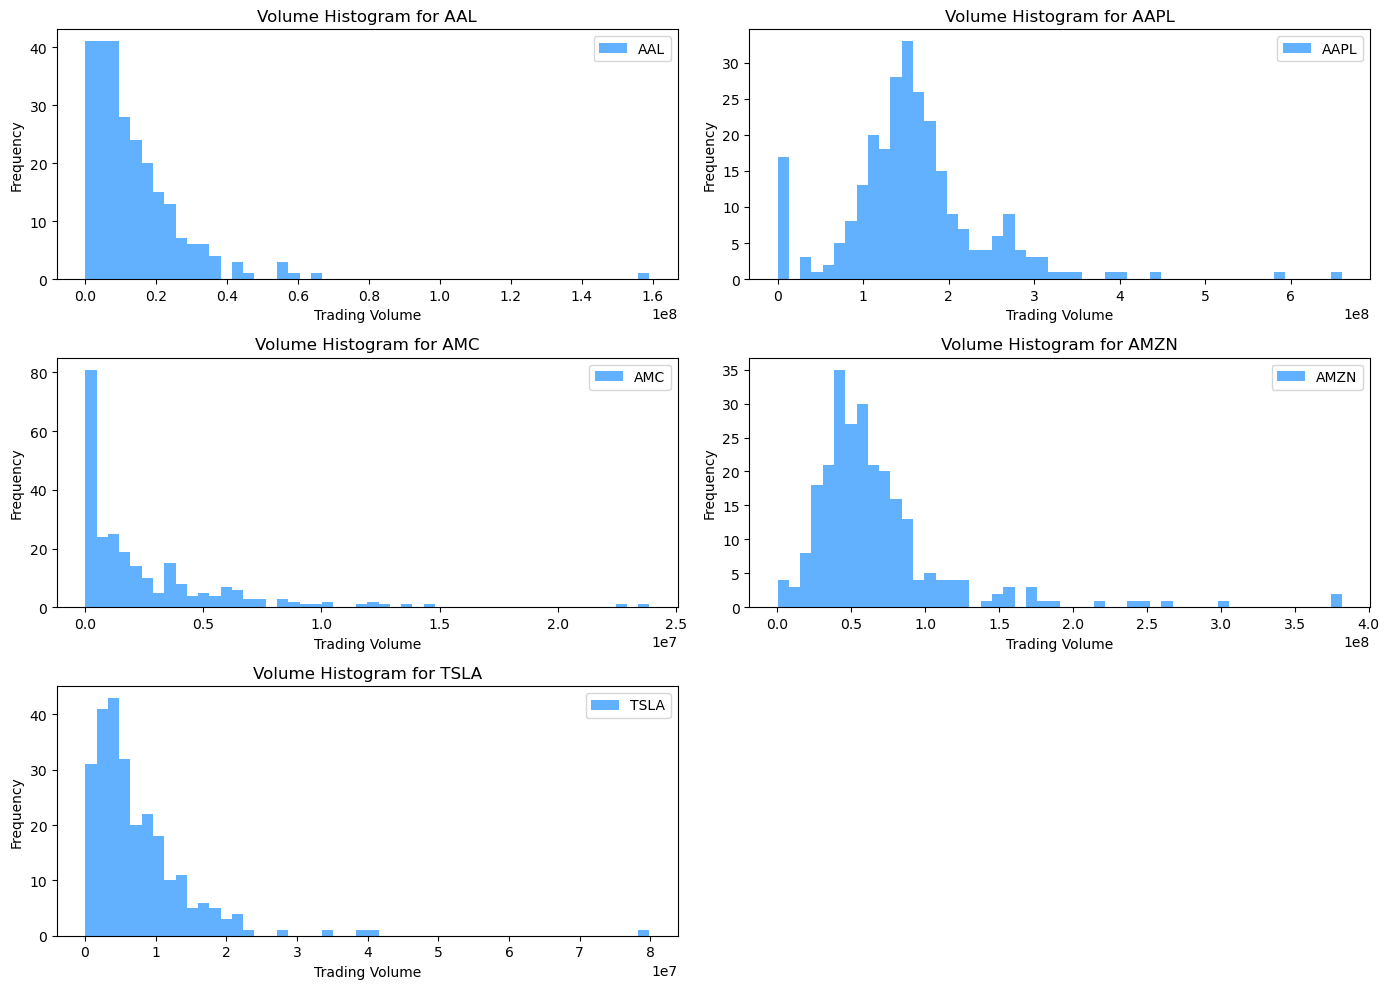

In [108]:
# Same as problem above, except we plot histograms
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, company in enumerate(companies):
    company_volume_data = daily_volumes[daily_volumes['company_symbol'] == company]
    axes[i].hist(company_volume_data['ascii_rptd_vol_tx'], bins=50, label=company, color='dodgerblue', alpha=0.7)
    axes[i].set_title(f'Volume Histogram for {company}')
    axes[i].set_xlabel('Trading Volume')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

# Adjust layout and remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
fig.tight_layout()

plt.show()

#### Get Daily trading info

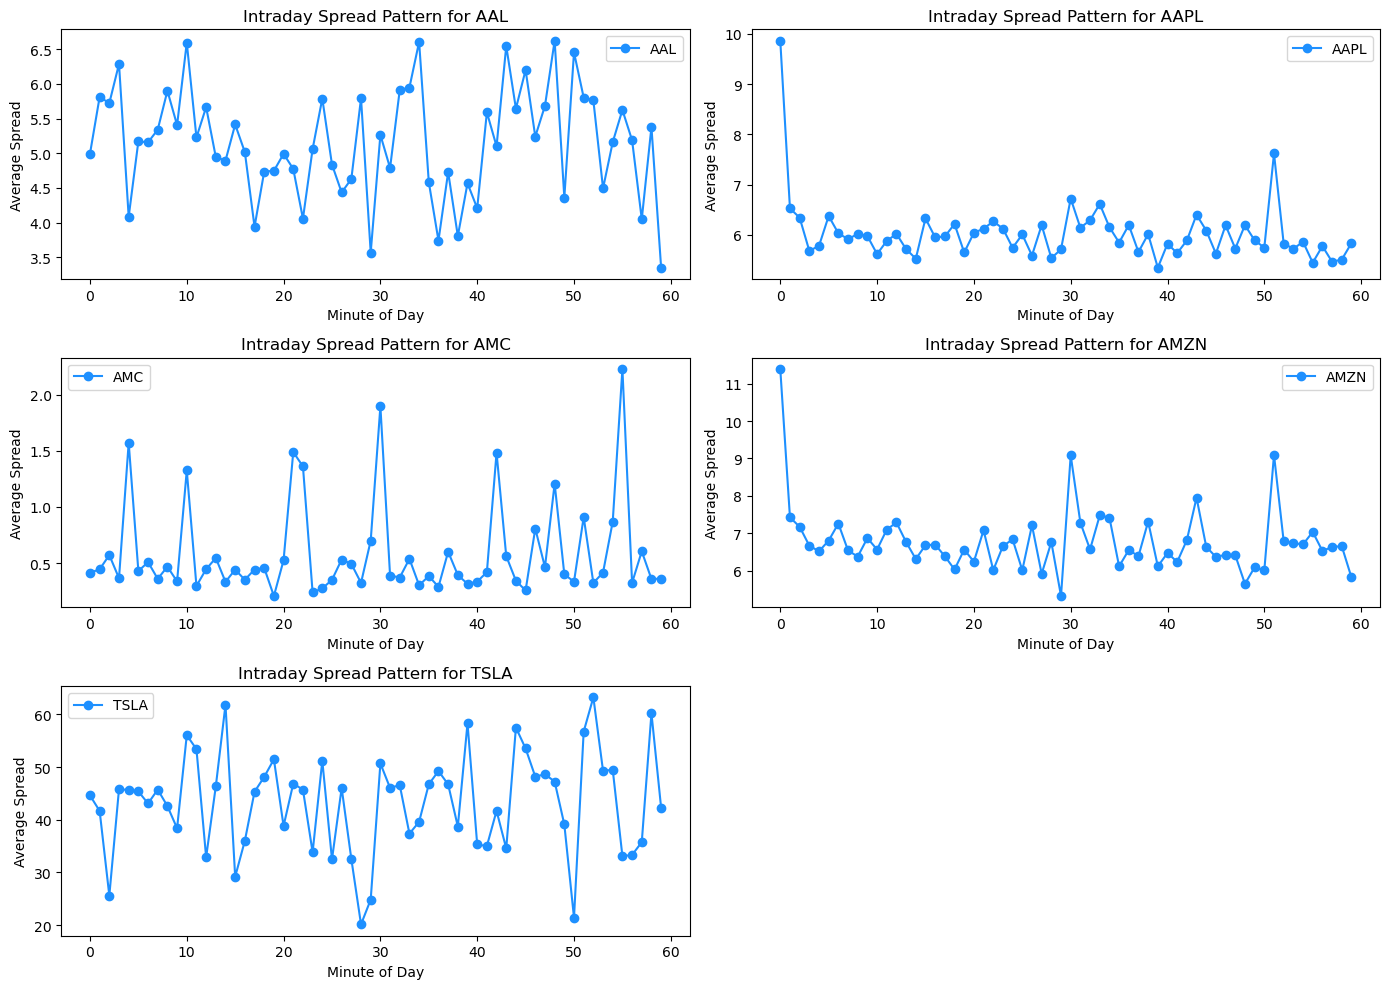

In [112]:
# For intraday analysis, convert 'trd_exctn_tm' back to a datetime format to extract minute information
df['trd_exctn_tm'] = pd.to_datetime(df['trd_exctn_tm'].astype(str))

# Calculate intraday spread and volume
intraday_spreads = df.groupby(['company_symbol', df['trd_exctn_dt'], df['trd_exctn_tm'].dt.minute])['rptd_pr'].std().reset_index()
intraday_volumes = df.groupby(['company_symbol', df['trd_exctn_dt'], df['trd_exctn_tm'].dt.minute])['ascii_rptd_vol_tx'].sum().reset_index()

# Rename columns for clarity
intraday_spreads.rename(columns={'rptd_pr': 'intraday_spread', 'trd_exctn_tm': 'minute'}, inplace=True)
intraday_volumes.rename(columns={'ascii_rptd_vol_tx': 'intraday_volume', 'trd_exctn_tm': 'minute'}, inplace=True)

# Plot though iteration (same as above)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
axes = axes.flatten()  # Flatten to iterate easily

for i, company in enumerate(companies):
    company_spread_data = intraday_spreads[intraday_spreads['company_symbol'] == company]
    avg_spread_per_minute = company_spread_data.groupby('minute')['intraday_spread'].mean()
    axes[i].plot(avg_spread_per_minute.index, avg_spread_per_minute.values, label=company, marker='o', linestyle='-', color='dodgerblue')
    axes[i].set_title(f'Intraday Spread Pattern for {company}')
    axes[i].set_xlabel('Minute of Day')
    axes[i].set_ylabel('Average Spread')
    axes[i].legend()

# Adjust layout and remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
fig.tight_layout()

plt.show()

#### Get Volume by minutes

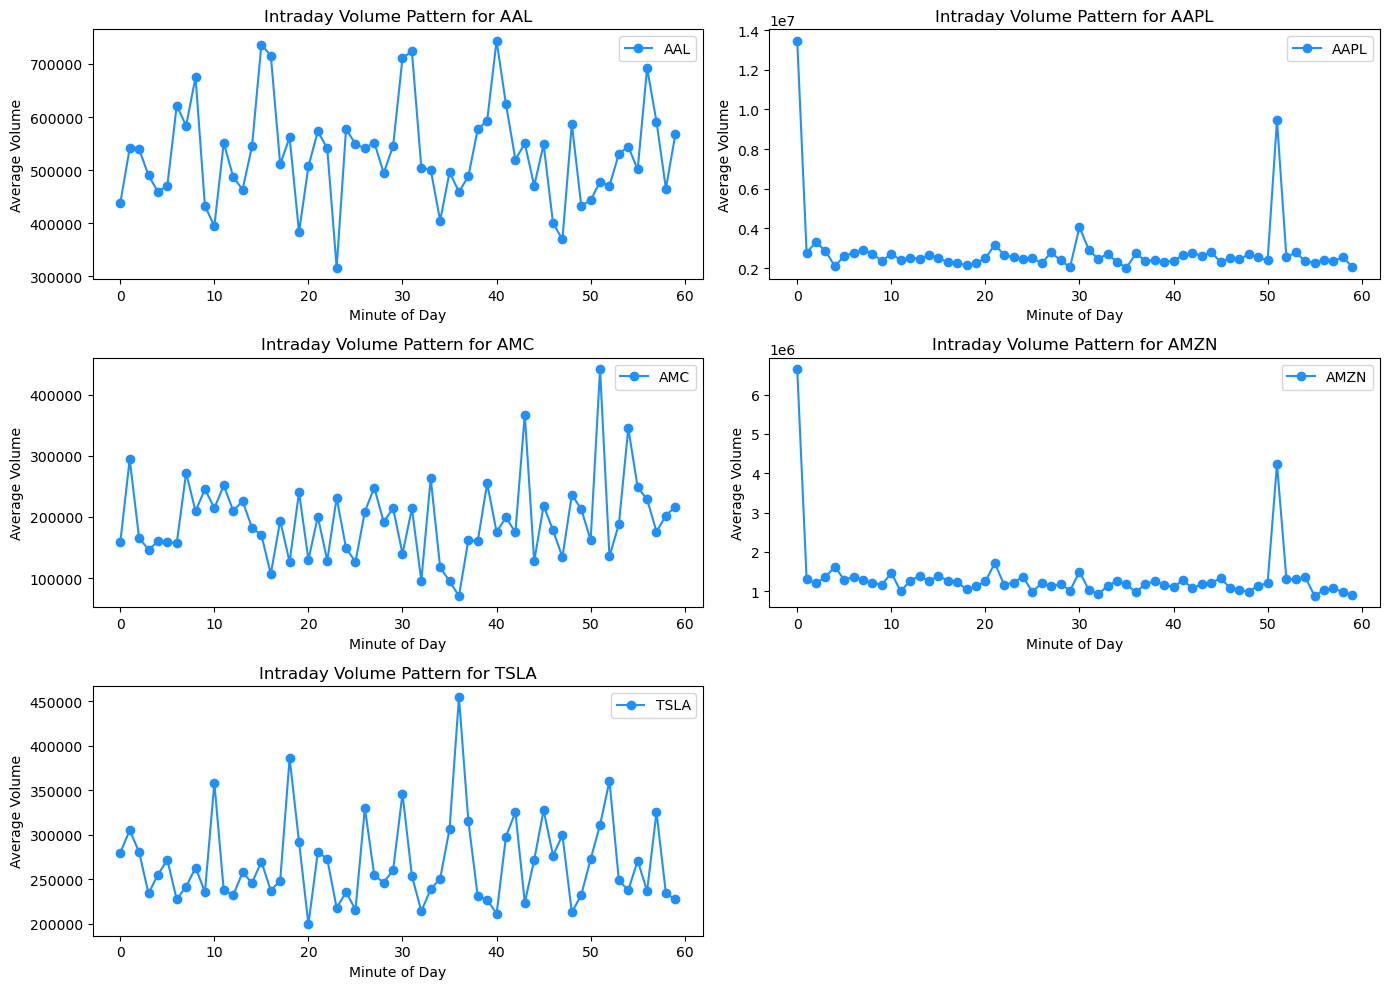

In [117]:
# Same thing as earlier but get the trading volume by minutes
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
axes = axes.flatten()  # Flatten to iterate easily

for i, company in enumerate(companies):
    company_volume_data = intraday_volumes[intraday_volumes['company_symbol'] == company]
    # Average volume per minute across all days
    avg_volume_per_minute = company_volume_data.groupby('minute')['intraday_volume'].mean()
    axes[i].plot(avg_volume_per_minute.index, avg_volume_per_minute.values, label=company, marker='o', linestyle='-', color='dodgerblue')
    axes[i].set_title(f'Intraday Volume Pattern for {company}')
    axes[i].set_xlabel('Minute of Day')
    axes[i].set_ylabel('Average Volume')
    axes[i].legend()

# Adjust layout and remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
fig.tight_layout()

plt.show()